<a href="https://colab.research.google.com/github/Tillmawitz/data_602/blob/main/vehicle_collision_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The dataset we are working with is the Motor Vehicle Collisions - Crashes data from the NYC Open Data project. This dataset records all motor vehicle accidents that occur in the city and is updated daily. This is a pretty interesting dataset as it has to make opinionated choices on how to account for data that can be recorded in different ways. For example, it tracks the location of the incident by lattitude and longitude as well as street names to try to provide as detailed a location as can be produced from the crash report. There are some interesting edge cases that we will look into, as well as some informative statistics that can be generated from the location data. The dataset can be found at https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data. The data set was retrieved on 2024/10/18 and stored as a parquet file in Google Drive due to the size of the dataset. Calling the API to fetch the dataset directly takes a long time, and the data does not need to be up to date for this project.

# Setting up libraries and importing the data


In [ ]:
!pip install pyodata
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
accident_df = pd.read_parquet(r'/content/drive/My Drive/data/Motor_Vehicle_Collisions_-_Crashes_20241018.parquet', engine='pyarrow')


# Data Exploration

Taking a quick look at a few rows of the data we can see there is a fair amount of missing data in each row.

In [ ]:
accident_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,None,None,NaN,NaN,None,WHITESTONE EXPRESSWAY,20 AVENUE,None,...,Unspecified,None,None,None,4455765,Sedan,Sedan,None,None,None
1,03/26/2022,11:45,None,None,NaN,NaN,None,QUEENSBORO BRIDGE UPPER,None,None,...,None,None,None,None,4513547,Sedan,None,None,None,None
2,06/29/2022,6:55,None,None,NaN,NaN,None,THROGS NECK BRIDGE,None,None,...,Unspecified,None,None,None,4541903,Sedan,Pick-up Truck,None,None,None
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",None,None,1211 LORING AVENUE,...,None,None,None,None,4456314,Sedan,None,None,None,None
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,None,...,None,None,None,None,4486609,None,None,None,None,None


We have over 60 million incident reports, which is a lot of data to comb through! Let's start by looking at how much of that data is missing.

In [ ]:
accident_df.size

61688452

The missing data can tell us a lot about the dataset. For starters it seems likely the columns with no missing values are required either for the reports that form the basis of the dataset or generated by the service that populates the dataset. Based on the columns missing the most data it seems likely most accidents involve fewer than 3 cars. Lastly, it seems the location data can be a little patchy. This could be due to different methods of data recording or the simple lack of a cross street near the accident.

In [ ]:
accident_df.isnull().sum().sort_values(ascending=False)

,0
VEHICLE TYPE CODE 5,2118027
CONTRIBUTING FACTOR VEHICLE 5,2117737
VEHICLE TYPE CODE 4,2093695
CONTRIBUTING FACTOR VEHICLE 4,2092457
VEHICLE TYPE CODE 3,1979966
CONTRIBUTING FACTOR VEHICLE 3,1974243
OFF STREET NAME,1764054
CROSS STREET NAME,810739
ZIP CODE,661805
BOROUGH,661545


Before going any further, we are going to clean up the column names to make them easier to reference later on.

In [ ]:
accident_df.rename(str.lower, axis='columns', inplace=True)
accident_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
accident_df.columns

Index(['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude',
       'longitude', 'location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5'],
      dtype='object')

Next we make some columns combining the injury and death counts for each accident into a single "harmed" column for the total and each subgroup.

In [ ]:
accident_df['persons_harmed'] = accident_df['number_of_persons_injured'] + accident_df['number_of_persons_killed']
accident_df['pedestrians_harmed'] = accident_df['number_of_pedestrians_injured'] + accident_df['number_of_pedestrians_killed']
accident_df['cyclists_harmed'] = accident_df['number_of_cyclist_injured'] + accident_df['number_of_cyclist_killed']
accident_df['motorists_harmed'] = accident_df['number_of_motorist_injured'] + accident_df['number_of_motorist_killed']

Looking at the average of injuries and deaths, we can see that most incidents do not result in any injuries or deaths. This makes looking at statistics like the mean, median, or quartiles for these statistics uninformative on a per accident basis. To learn more from the data, we will need to group it.

In [ ]:
stats_columns = ['number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'persons_harmed', 'pedestrians_harmed', 'cyclists_harmed', 'motorists_harmed']

accident_statistics = accident_df.loc[:, stats_columns]
accident_statistics.mean()

,0
number_of_persons_injured,0.317024
number_of_persons_killed,0.001531
number_of_pedestrians_injured,0.057427
number_of_pedestrians_killed,0.000754
number_of_cyclist_injured,0.027720
number_of_cyclist_killed,0.000119
number_of_motorist_injured,0.227789
number_of_motorist_killed,0.000634
persons_harmed,0.318544
pedestrians_harmed,0.058182


We will start by looking at some summary statistics by day. The day with the fewest people harmed was 2015-01-27, and the day with the most people harmed was 2017-05-18

In [ ]:
harmed_by_day = accident_df[['crash_date', 'persons_harmed']].groupby('crash_date').sum('persons_harmed')
harmed_by_day[harmed_by_day['persons_harmed'] == harmed_by_day['persons_harmed'].min()]

,persons_harmed
crash_date,
01/27/2015,21.0


In [ ]:
harmed_by_day[harmed_by_day['persons_harmed'] == harmed_by_day['persons_harmed'].max()]

,persons_harmed
crash_date,
05/18/2017,312.0


Looking at the quartiles we can see there appears to be a pretty consistent range of individuals harmed per day.

In [ ]:
harmed_by_day.quantile([.25, .5, .75])

,persons_harmed
0.25,131.0
0.50,152.0
0.75,172.0


Plotting the daily harmed counts we can see the data is actually very normally distributed. Given it is a time series you could easily generate some accurate models, but that is beyond the scope of this assignment. As a note, we need to convert the crash_date column to a datetime in order to achieve this plot.

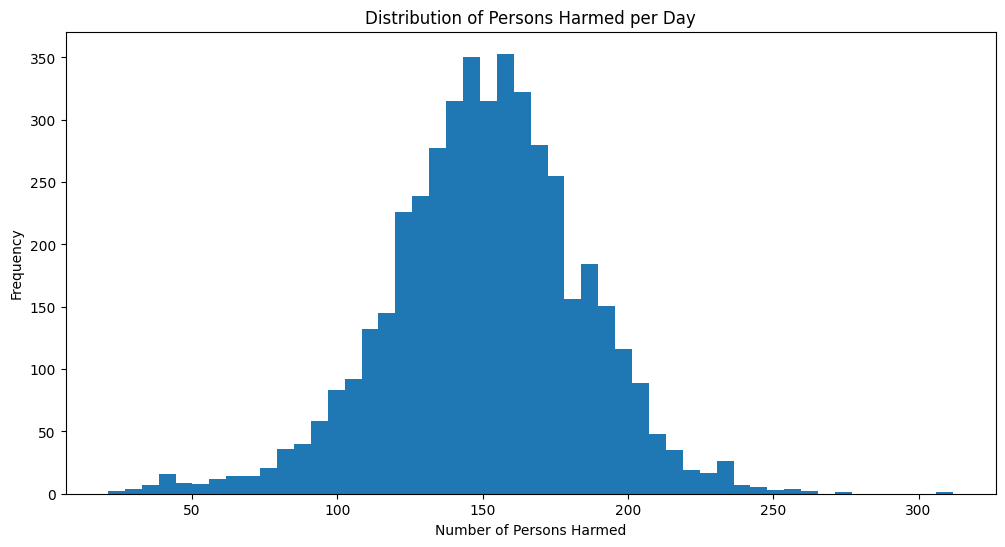

In [ ]:
accident_df["crash_date"] = pd.to_datetime(accident_df["crash_date"])

plt.figure(figsize=(12, 6))
plt.hist(harmed_by_day['persons_harmed'], bins=50)
plt.xlabel('Number of Persons Harmed')
plt.ylabel('Frequency')
plt.title('Distribution of Persons Harmed per Day')
plt.show()

Since every accident has a date, we can track which day of the week each accident occured on. Now we can use statistics to learn which day of the week is most dangerous.

In [ ]:
accident_df["weekday"] = accident_df["crash_date"].dt.day_name()

Sorting by average total people harmed per day of the week we can see that there is a generally increasing trend as the week goes on with the most dangerous days at the end of the week.



In [ ]:
daily_stats_columns = stats_columns + ['crash_date']
daily_stats = accident_df.loc[:, daily_stats_columns].groupby('crash_date').sum(numeric_only=True)
daily_stats = daily_stats.reset_index()
daily_stats['weekday'] = daily_stats["crash_date"].dt.day_name()

avg_daily_stats = daily_stats.groupby('weekday').mean()
avg_daily_stats[['persons_harmed']].sort_values('persons_harmed', ascending=False)

,persons_harmed
weekday,
Friday,162.868955
Saturday,152.602184
Thursday,150.968799
Tuesday,150.109204
Wednesday,149.360374
Monday,147.001558
Sunday,143.719626


We can cross check our conclusion by comparing the average daily harm to the median daily harm in case any outliers are skewing the data, although with this much data that is unlikely. As we can see the ordering is exactly the same and the median and mean are very close, something we would expect from normally distributed data.

In [ ]:
med_daily_stats = daily_stats.groupby('weekday').median('persons_harmed')
med_daily_stats[['persons_harmed']].sort_values('persons_harmed', ascending=False)

,persons_harmed
weekday,
Friday,163.0
Saturday,153.0
Thursday,152.0
Tuesday,150.0
Wednesday,150.0
Monday,147.5
Sunday,145.0


Digging in a little deeper let's look at whether there is a difference between the days with the most injuries and the most deaths. Put another way, are some days of the week deadlier than others? Looking at the average deaths per day of the week the weekend, with Saturday in particular, is more deadly than the weekdays. The further a day is from the weekend, the fewer deaths there are on average.

In [ ]:
avg_daily_stats[['number_of_persons_killed']].sort_values('number_of_persons_killed', ascending=False)

,number_of_persons_killed
weekday,
Saturday,0.819033
Sunday,0.780374
Monday,0.766355
Friday,0.755070
Thursday,0.684867
Tuesday,0.655226
Wednesday,0.616225


If we are just looking at injuries the data is slightly different. Friday is far more dangerous than the other days, with Sunday much safer. The rank difference between deaths and injuries for Sunday is especially noteworthy, while Saturday appears to be the most consistently dangerous day by both measures.

In [ ]:
avg_daily_stats[['number_of_persons_injured']].sort_values('number_of_persons_injured', ascending=False)

,number_of_persons_injured
weekday,
Friday,162.113885
Saturday,151.798752
Thursday,150.294852
Tuesday,149.463339
Wednesday,148.747270
Monday,146.239875
Sunday,142.939252


Breaking things down into the subgroups of people we first look at cyclists. Interestingly the weekend is pretty safe for cyclists which runs counter to our findings for the whole population, although Friday is still the most dangerous day by far.

In [ ]:
avg_daily_stats[['cyclists_harmed']].sort_values('cyclists_harmed', ascending=False)

,cyclists_harmed
weekday,
Friday,14.602184
Wednesday,13.970359
Thursday,13.962559
Tuesday,13.650546
Monday,12.556075
Saturday,12.522621
Sunday,11.084112


Pedestrians follow a pretty similar trend to cyclists just more extreme on the safe days. The weekend is much safer than weekdays, with Sunday having only 2/3 the injuries Friday has. Friday is still the most dangerous day, although by a smaller margin than for cyclists.

In [ ]:
avg_daily_stats[['pedestrians_harmed']].sort_values('pedestrians_harmed', ascending=False)

,pedestrians_harmed
weekday,
Friday,31.285491
Thursday,30.078003
Tuesday,30.059282
Wednesday,29.783151
Monday,28.271028
Saturday,23.819033
Sunday,19.707165


Motorists make up the majority of those injured in accidents by a large margin, and we can see that while Friday is the most dangerous the weekend is much more dangerous than the remaining weekdays. Interestingly the ranking of dangerous days for motorists is close to an inverse for that of pedestrians, excluding Friday.

In [ ]:
avg_daily_stats[['motorists_harmed']].sort_values('motorists_harmed', ascending=False)

,motorists_harmed
weekday,
Friday,114.825273
Saturday,114.405616
Sunday,111.210280
Thursday,104.939158
Monday,104.370717
Tuesday,104.341654
Wednesday,103.600624


Now that we know which days are the most dangerous, let's see if there are any differences by borough by day. First let's make sure the boroughs are all accounted for properly. Weirdly, there appears to be a category for no borough! Before looking into that though, let's make the names a bit easier on the eyes.

In [ ]:
accident_df.borough.unique()

array([None, 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [ ]:
accident_df['borough'] = accident_df['borough'].astype('string').str.capitalize()
accident_df.borough.unique()

<StringArray>
[<NA>, 'Brooklyn', 'Bronx', 'Manhattan', 'Queens', 'Staten island']
Length: 6, dtype: string

Now let's take a peak at what those empty boroughs are. It appears these entries are a combination of bridges, tunnels, expressways, and a few accidents which just did not record a borough. For the rest of our analysis we will filter these out since they do not make a large proportion of entries.

In [ ]:
accident_df[accident_df['borough'].isnull()]

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,persons_harmed,pedestrians_harmed,cyclists_harmed,motorists_harmed,weekday
0,2021-09-11,2:39,<NA>,None,NaN,NaN,None,WHITESTONE EXPRESSWAY,20 AVENUE,None,...,Sedan,Sedan,None,None,None,2.0,0,0,2,Saturday
1,2022-03-26,11:45,<NA>,None,NaN,NaN,None,QUEENSBORO BRIDGE UPPER,None,None,...,Sedan,None,None,None,None,1.0,0,0,1,Saturday
2,2022-06-29,6:55,<NA>,None,NaN,NaN,None,THROGS NECK BRIDGE,None,None,...,Sedan,Pick-up Truck,None,None,None,0.0,0,0,0,Wednesday
5,2021-04-14,12:47,<NA>,None,NaN,NaN,None,MAJOR DEEGAN EXPRESSWAY RAMP,None,None,...,Dump,Sedan,None,None,None,0.0,0,0,0,Wednesday
6,2021-12-14,17:05,<NA>,None,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,None,None,...,Sedan,Tractor Truck Diesel,None,None,None,0.0,0,0,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127182,2024-08-06,9:00,<NA>,None,40.664960,-73.822260,"(40.66496, -73.82226)",BELT PARKWAY,None,None,...,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,None,None,None,1.0,0,0,1,Tuesday
2127183,2024-08-06,20:39,<NA>,None,NaN,NaN,None,CLEARVIEW EXPRESSWAY,35 AVENUE,None,...,Station Wagon/Sport Utility Vehicle,Sedan,None,None,None,0.0,0,0,0,Tuesday
2127185,2024-07-29,2:30,<NA>,None,40.723442,-73.938990,"(40.723442, -73.93899)",BROOKLYN QUEENS EXPRESSWAY,None,None,...,Tractor Truck Diesel,Sedan,None,None,None,0.0,0,0,0,Monday
2127186,2024-08-02,15:48,<NA>,None,NaN,NaN,None,THROGS NECK BRIDGE,None,None,...,Sedan,Pick-up Truck,None,None,None,0.0,0,0,0,Friday


Breaking the average people harmed down by borough and day we can see that Brooklyn is by far the most dangerous borough any day of the week, whereas Staten Island is consistently the safest by a large margin. You go Staten Island. Queens handily follows Brooklyn as the most dangerous, with Manhattan and the Bronx intermingled.

In [ ]:
just_boroughs = accident_df[accident_df['borough'].notnull()]
borough_stats_columns = stats_columns + ['crash_date', 'borough']
borough_daily_stats = just_boroughs.loc[:, borough_stats_columns].groupby(['crash_date', 'borough']).sum(numeric_only=True)

borough_daily_stats.reset_index(inplace=True)
borough_daily_stats['weekday'] = borough_daily_stats["crash_date"].dt.day_name()
borough_weekday_stats = borough_daily_stats.groupby(['borough', 'weekday']).mean()

borough_weekday_stats[['persons_harmed']].sort_values('persons_harmed', ascending=False)

persons_harmed
borough       weekday                  
Brooklyn      Friday          37.416537
              Tuesday         35.669267
              Thursday        35.502340
              Monday          35.467290
              Wednesday       35.391576
              Saturday        34.145086
              Sunday          33.473520
Queens        Friday          29.580343
              Saturday        27.234009
              Thursday        27.120125
              Monday          27.066978
              Tuesday         26.925117
              Wednesday       26.633385
              Sunday          24.889408
Bronx         Friday          18.414977
Manhattan     Friday          17.090484
              Thursday        16.599064
              Wednesday       16.368175
Bronx         Saturday        16.335413
              Thursday        16.190328
              Tuesday         16.143526
Manhattan     Tuesday         16.106084
Bronx         Monday          15.936137
              Wednesday       15.900156
Manhattan     Saturday        15.767551
Bronx         Sunday          14.654206
Manhattan     Monday          14.570093
              Sunday          14.247664
Staten island Wednesday        4.391576
              Friday           4.273011
              Tuesday          4.182527
              Thursday         4.180967
              Monday           4.095016
              Saturday         3.755070
              Sunday           3.076443

Plotting the data helps us understand the overall patterns. We can see that all the boroughs follow approximately the same pattern, with injuries hitting their lowest point on Wednesday before jumping to the peak on Friday and remaining high over the weekend.

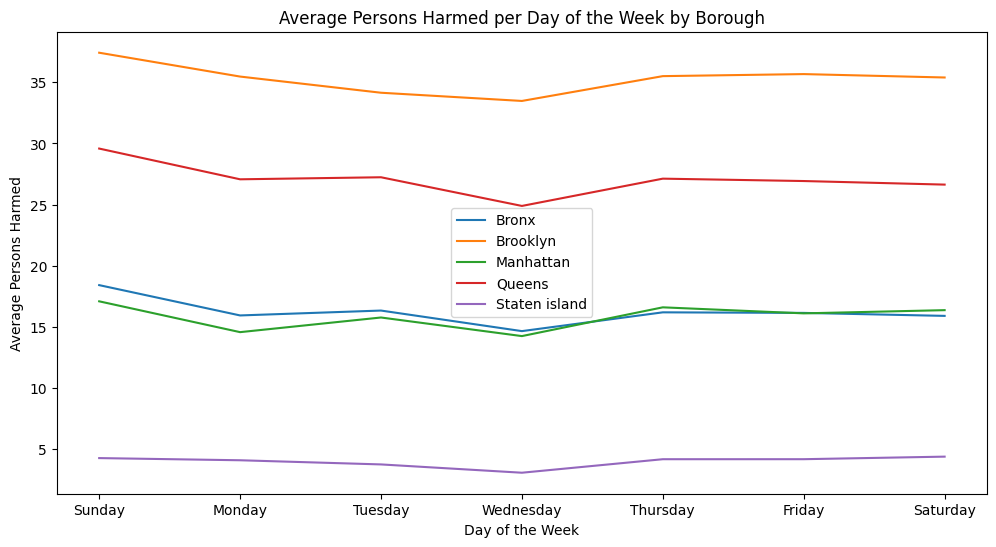

In [ ]:
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(12, 6))

for borough in borough_weekday_stats.index.get_level_values('borough').unique():
  borough_data = borough_weekday_stats.xs(borough, level='borough')
  plt.plot(borough_data['persons_harmed'], label=borough)

plt.xticks(range(len(weekday_order)), weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Average Persons Harmed')
plt.title('Average Persons Harmed per Day of the Week by Borough')
plt.legend()
plt.show()

# Final wrangling

This section contains portions of the assignment which we have not explicitly dealt with during our prior analysis, although all situations can be recognized as being addressed in the above code.

In [ ]:
# Checking if a column is numeric

if pd.api.types.is_numeric_dtype(accident_df['longitude']):
  print("The 'longitude' column is numeric.")
else:
  print("The 'longitude' column is not numeric.")

The 'longitude' column is numeric.


In [ ]:
# drop the last row of accident_df

accident_df = accident_df.drop(accident_df.index[-1])

I won't bother converting a column to upper or lowercase since we used capitalize above and that is essentially the same function.

# Conclusion

Our analysis has shown that Brooklyn is the most dangerous borough with regards to the persons harmed per day, with Staten Island being significantly safer than the other boroughs. Be vigilant on Fridays, as they are the most dangerous day anywhere in the city.

There are so many more ways we can parse this data to gain a better understanding of how vehicular accidents affect the city. Of particular interest would be checking if accidents involving more vehicles are more or less dangerous as well as whether the type of vehicles involved impacts injuries or mortality. We could also continue the analysis we have by further considering time of day to see if certain periods are more dangerous than others.